In [62]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np


In [63]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [64]:
df = pd.read_csv("file_train_senza_outliers.csv")

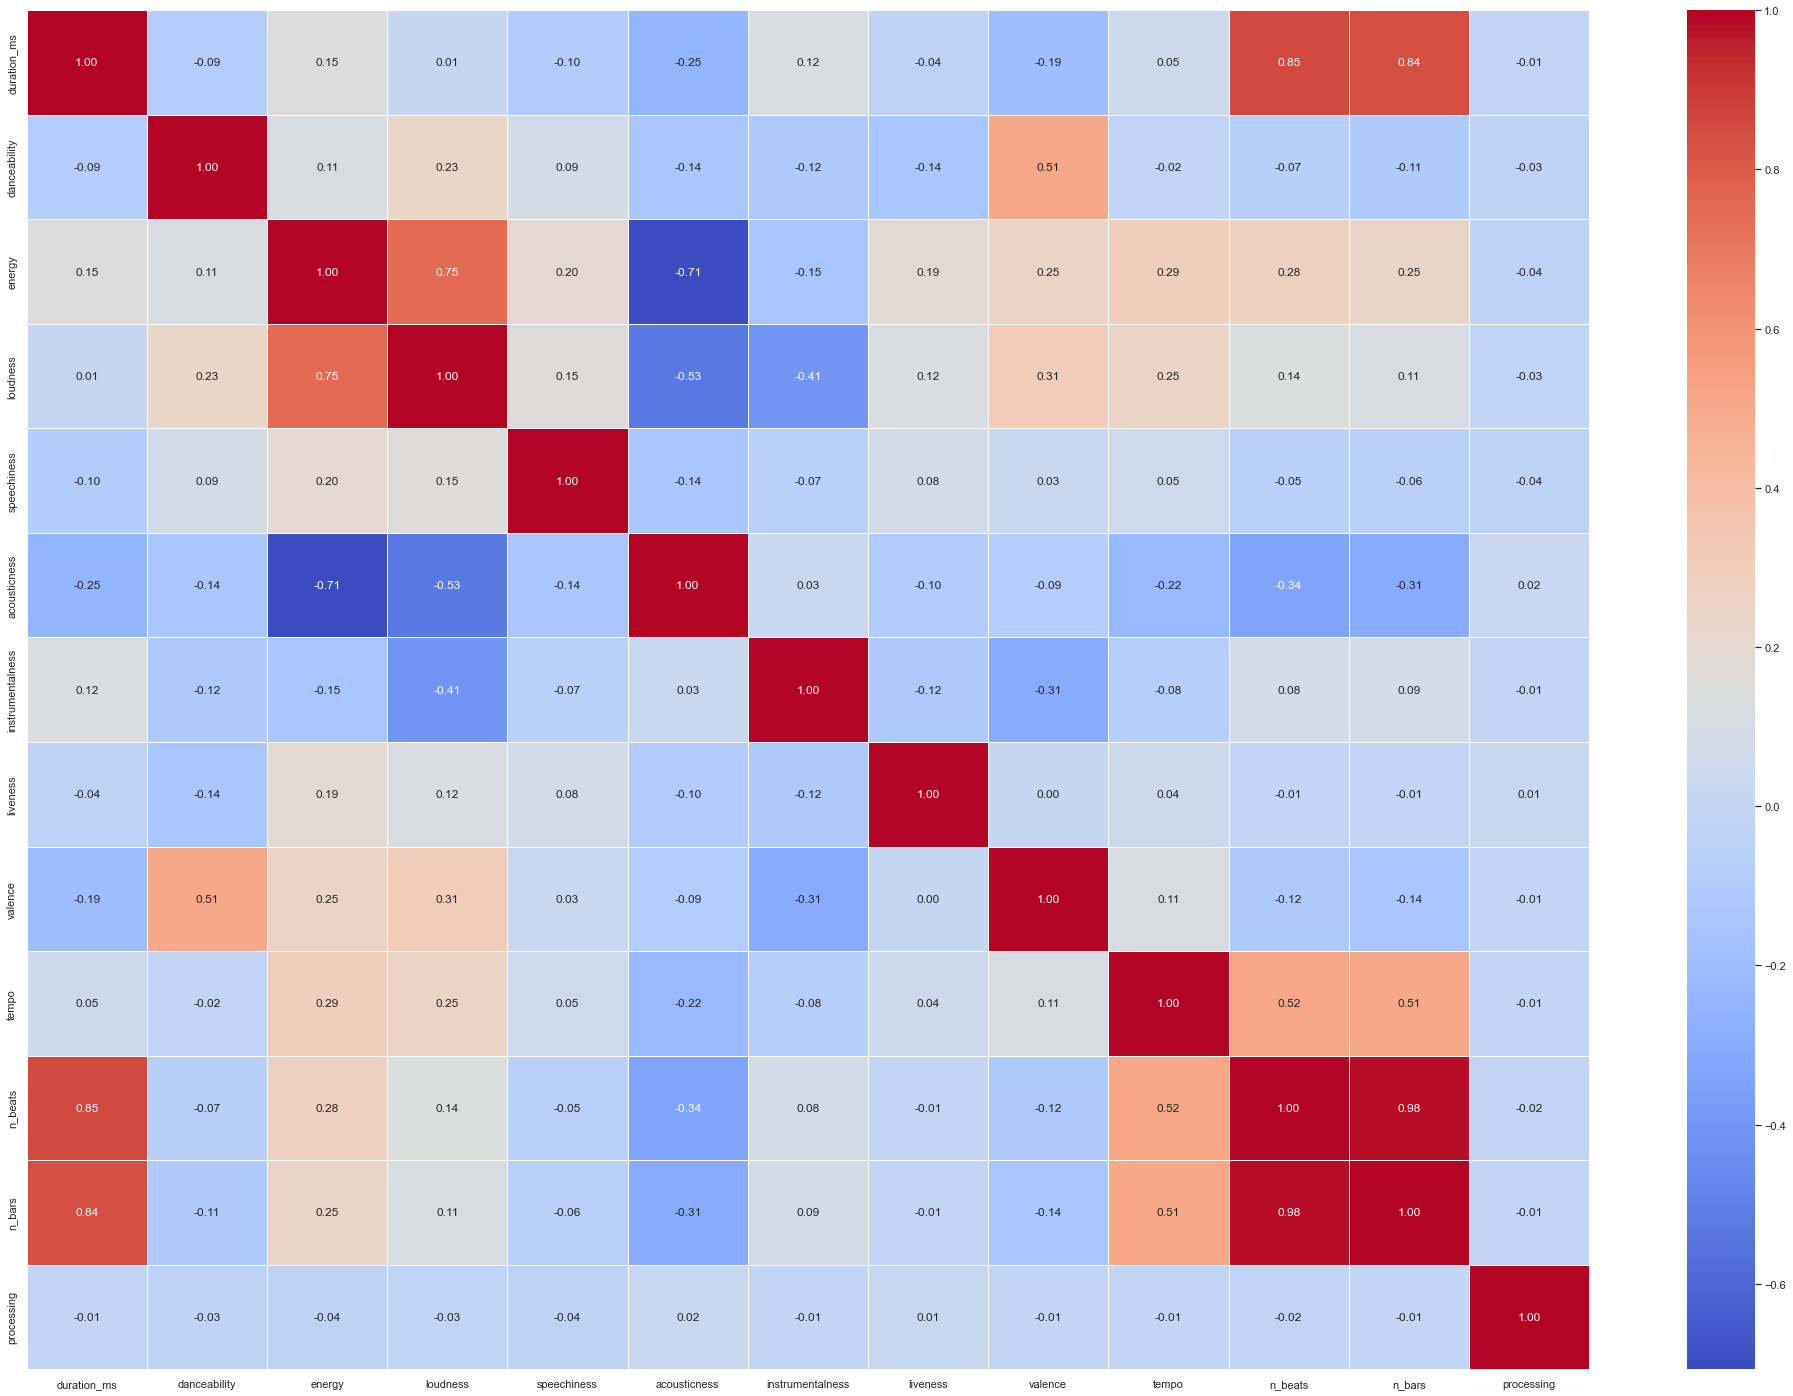

In [65]:
selected_columns = df[['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'n_beats', 'n_bars', 'processing']]

plt.figure(figsize = (35, 25))
sns.heatmap(selected_columns.corr(),cmap='coolwarm', annot=True, fmt=".2f", linewidth='.8') 
sns.set(font_scale=1)

In [66]:
X = df.select_dtypes(include=float).values
#y = np.array(df['target'])
#y_map = {0: "setosa", 1: "versicolor", 2: "virginica"}
#y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map)

In [67]:
# z-score, fit and then transform
scaler = StandardScaler()
scaler.fit(X)
X_scal = scaler.transform(X)

In [68]:
# min-max, fit and trasform directly
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

In [69]:
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=100)
kmeans.fit(X_minmax)

KMeans(max_iter=100, n_clusters=2, n_init=10)

In [70]:
kmeans.labels_

array([1, 0, 1, ..., 1, 1, 1])

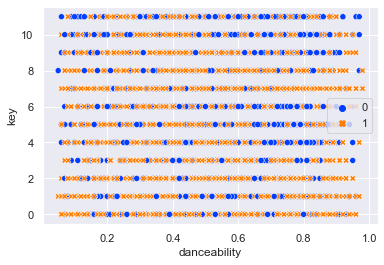

In [71]:
sns.scatterplot(data=df, 
                x="danceability",
                y="key",
                hue=kmeans.labels_,
                style=kmeans.labels_,
                palette="bright")
plt.show()

## DBScan

In [72]:
dist = pdist(X_minmax, 'euclidean')
dist = squareform(dist)

In [73]:
k=3
kth_distances = []
for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list

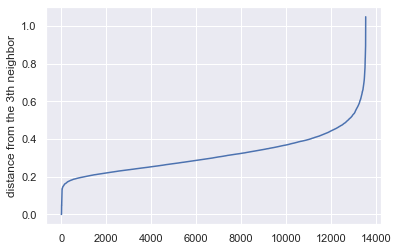

In [74]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('distance from the {}th neighbor'.format(k))
         
plt.show()

In [75]:
dbscan = DBSCAN(eps=0.50, min_samples=4, metric='precomputed')
dbscan.fit(dist)

DBSCAN(metric='precomputed', min_samples=4)

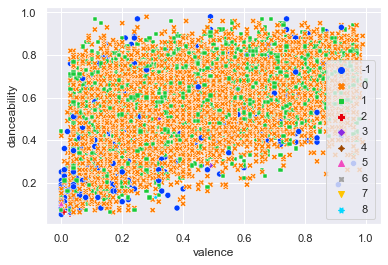

In [76]:
sns.scatterplot(data=df, 
                x="valence", 
                y="danceability", 
                hue=dbscan.labels_, 
                style=dbscan.labels_, 
                palette="bright")
plt.show()

## C-Means (fuzzy means)

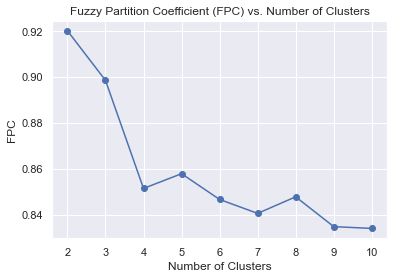

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

# Extract the data from the two columns of interest
data = df.select_dtypes(include=float).values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Define a range of cluster numbers to try
num_clusters = range(2, 11)  # Try clusters from 2 to 10

# Lists to store FPC values for each cluster number
fpc_values = []

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Perform Fuzzy C-Means clustering for each cluster number
for c in num_clusters:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data.T, c, m, error=tolerance, maxiter=max_iters, init=None
    )
    fpc_values.append(fpc)

# Plot the FPC values against the number of clusters
plt.plot(num_clusters, fpc_values, marker='o')
plt.title('Fuzzy Partition Coefficient (FPC) vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('FPC')
plt.show()

Fuzzy Partition Coefficient (FPC): 0.9667942497974557


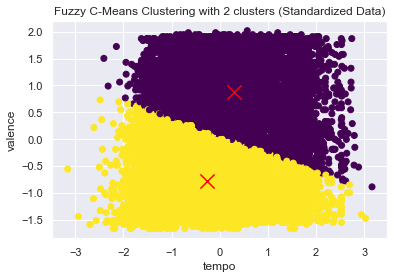

Davies–Bouldin Index: 3.1602342730613744


In [95]:
#!pip install  scikit-fuzzy

import skfuzzy as fuzz

# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["tempo", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Number of clusters
c = 2

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_scaled.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)


# Visualize the data and cluster centers
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Standardized Data)')
plt.xlabel("tempo")
plt.ylabel("valence")
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()




from sklearn.metrics import pairwise_distances
import numpy as np

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")


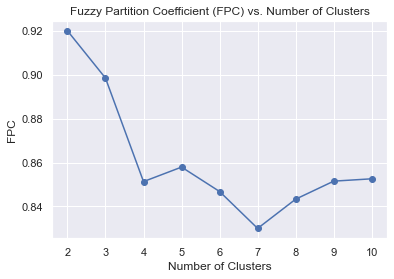

Fuzzy Partition Coefficient (FPC): 0.965828363032804


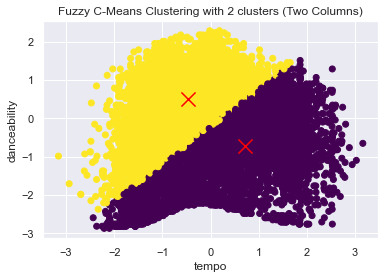

Davies–Bouldin Index: 3.0556674975494675


In [96]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["tempo", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 2

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("tempo")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.967512819243978


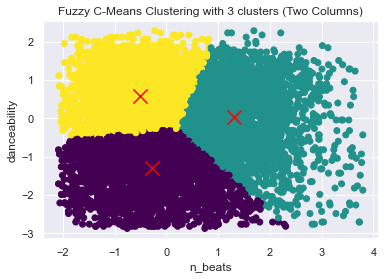

Davies–Bouldin Index: 4.0640609987065845


In [80]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["n_beats", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("n_beats")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9688605098453169


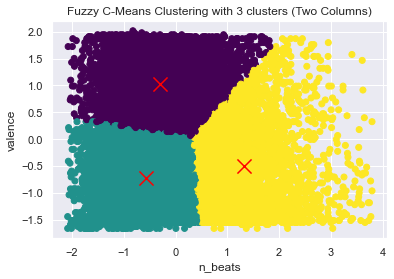

Davies–Bouldin Index: 3.898702919108161


In [81]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["n_beats", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("n_beats")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()


# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")


Fuzzy Partition Coefficient (FPC): 0.9682664759057268


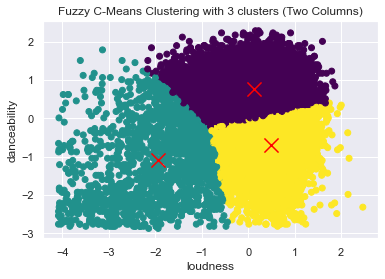

Davies–Bouldin Index: 4.870344266204589


In [82]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["loudness", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("loudness")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9732161052114582


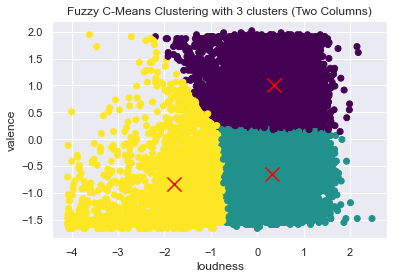

Davies–Bouldin Index: 4.472247641210161


In [83]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["loudness", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("loudness")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()


# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.972892411209228


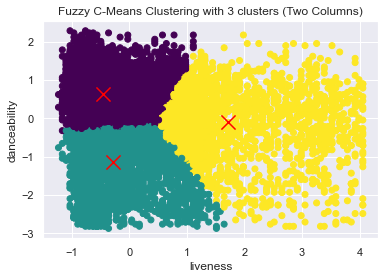

Davies–Bouldin Index: 4.588395741654025


In [84]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["liveness", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("liveness")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9737918845566469


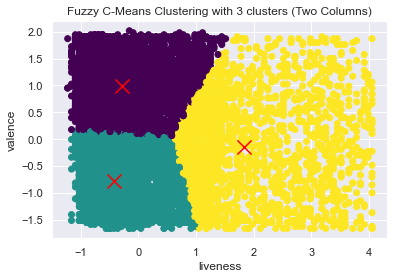

Davies–Bouldin Index: 4.728216247160156


In [85]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["liveness", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("liveness")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9728548405968934


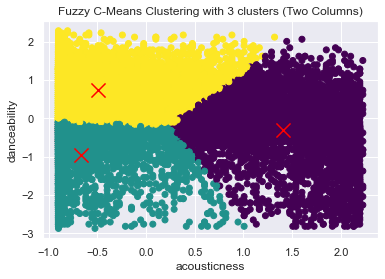

Davies–Bouldin Index: 4.04339177035384


In [86]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["acousticness", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("acousticness")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.976929861803469


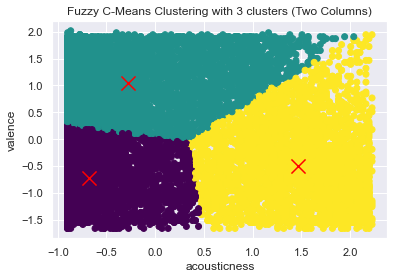

Davies–Bouldin Index: 4.35289109306418


In [87]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["acousticness", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("acousticness")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()


# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9776449899830681


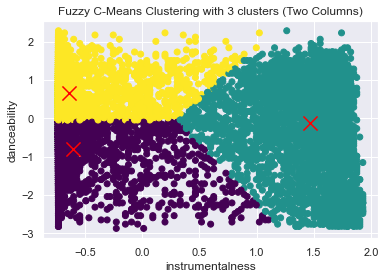

Davies–Bouldin Index: 3.7100548486381295


In [88]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["instrumentalness", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("instrumentalness")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()


# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")


Fuzzy Partition Coefficient (FPC): 0.9793669735793968


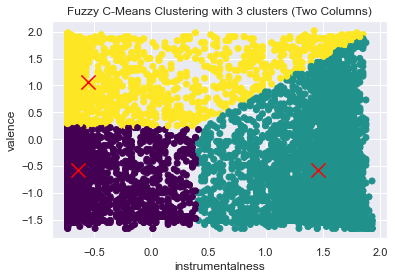

Davies–Bouldin Index: 4.101549560750205


In [89]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["instrumentalness", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("instrumentalness")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")


Fuzzy Partition Coefficient (FPC): 0.9636378973254829


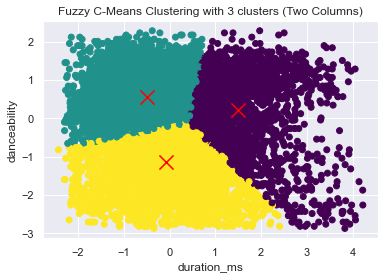

Davies–Bouldin Index: 3.9919341668963724


In [90]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["duration_ms", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("duration_ms")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()


# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")



Fuzzy Partition Coefficient (FPC): 0.9691001963993577


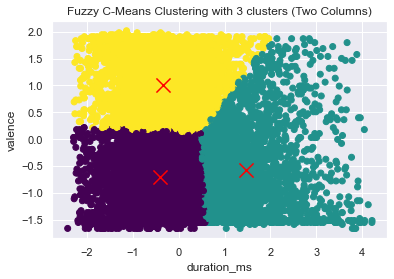

Davies–Bouldin Index: 3.879084641458913


In [91]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["duration_ms", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("duration_ms")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")


Fuzzy Partition Coefficient (FPC): 0.9755478695745329


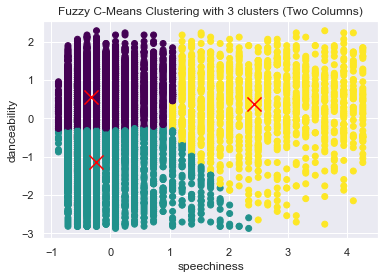

Davies–Bouldin Index: 6.2338554042919165


In [92]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["speechiness", "danceability"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("speechiness")
plt.ylabel("danceability")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()


# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")


Fuzzy Partition Coefficient (FPC): 0.9800749240454856


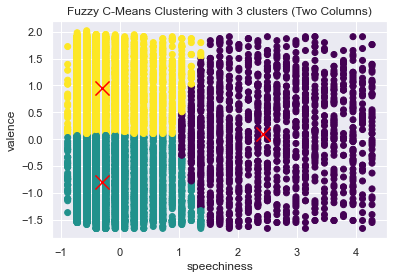

Davies–Bouldin Index: 6.225434888236706


In [93]:
# Load your data into a DataFrame or use your existing DataFrame
# For example:
# df = pd.read_csv('your_data.csv')

# Extract the data from the two columns of interest
data = df[["speechiness", "valence"]].values

# Standardize (z-score normalize) the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Number of clusters
c = 3

# Fuzziness coefficient (typically between 1.1 and 2.0)
m = 1.1

# Maximum number of iterations
max_iters = 100

# Tolerance (stop when change in membership is smaller than this)
tolerance = 1e-3

# Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, c, m, error=tolerance, maxiter=max_iters, init=None
)

# Get the cluster membership degrees
cluster_membership = np.argmax(u, axis=0)

# Visualize the data and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_membership, cmap='viridis')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x', s=200)
plt.xlabel("speechiness")
plt.ylabel("valence")
plt.title(f'Fuzzy C-Means Clustering with {c} clusters (Two Columns)')
print(f"Fuzzy Partition Coefficient (FPC): {fpc}")
plt.show()

# Calculate pairwise distances between cluster centers
center_distances = pairwise_distances(cntr)

# Initialize Davies–Bouldin index
db_index = 0.0

# Iterate through each cluster
for i in range(c):
    # Calculate average distance within the cluster
    avg_distance_within_cluster = np.mean([center_distances[i, j] for j in range(c) if j != i])
    
    # Find the cluster with the maximum similarity (maximum value of (std_i + std_j) / distance_ij)
    max_similarity = max([(np.std(u[i]) + np.std(u[j])) / center_distances[i, j] for j in range(c) if j != i])
    
    # Update Davies–Bouldin index
    db_index += avg_distance_within_cluster / max_similarity

# Calculate the final Davies–Bouldin index
db_index /= c

print(f"Davies–Bouldin Index: {db_index}")
